In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import time
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [2]:
def plot_scores_box_plot(scores, repeats, n_splits):
    plt.figure(figsize=(15, 8))
    plt.boxplot(
        scores.reshape((repeats, n_splits)),
        labels=[str(r) for r in range(1, repeats + 1)],
        showmeans=True,
    )
    plt.ylabel("RMSE", labelpad=20, fontsize=15)
    plt.xlabel("Repeats", labelpad=20, fontsize=15)
    plt.show()

In [3]:
def create_keras_model(
    activation="swish", dropout_rate=0.0, n_units=0, n_layers=0, learning_rate=1e-3
):
    model = tf.keras.Sequential()

    for _ in range(n_layers):
        model.add(tf.keras.layers.Dense(units=n_units, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
    )
    return model

In [4]:
def get_baseline_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(units=32))
    model.add(tf.keras.layers.Dense(units=1))
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(
        optimizer=opt,
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
    )
    return model

In [5]:
def make_repeated_kfold_cross_validation(x, y, params=None):
    if params is not None:
        activation = params["activation"]
        dropout_rate = params["dropout_rate"]
        n_units = params["n_units"]
        n_layers = params["n_layers"]
        learning_rate = params["learning_rate"]

    rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)
    scores = []

    start = time.time()
    for train, test in rkf.split(x):
        if params is not None:
            model = create_keras_model(
                activation=activation,
                dropout_rate=dropout_rate,
                n_units=n_units,
                n_layers=n_layers,
                learning_rate=learning_rate,
            )
        else:
            model = get_baseline_model()
        model.fit(
            scaler.fit_transform(x[train]),
            y[train],
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
        )
        rmse = model.evaluate(scaler.transform(x[test]), y[test], verbose=0)
        scores.append(rmse[1])

    print("RMSE: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))
    end = time.time()
    print("Minutes Elapsed: ", (end - start) / 60)
    return rkf, scores

<h3>Disable Tensorflow Warnings</h3>

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# FFT Transform

This notebook contains that experiments with the data transformed with fast fourier transform.

In [7]:
df_r3d_and_r7d = pd.read_csv(
    "../../../../data/interim/"
    + "r3d_and_r7d-no-resampling-with-fillna-and-fft-all-vars-kept-"
    + "dados-historicos-partner_i-cement-CPIIF40.csv"
)
df_r3d_only = pd.read_csv(
    "../../../../data/interim/"
    + "r3d_only-no-resampling-with-fillna-and-fft-all-vars-kept-"
    + "dados-historicos-partner_i-cement-CPIIF40.csv"
)
df_no_r3d_r7d = pd.read_csv(
    "../../../../data/interim/"
    + "no-r3d-r7d-no-resampling-with-fillna-and-fft-all-vars-kept-"
    + "dados-historicos-partner_i-cement-CPIIF40.csv"
)

# Neural Network Feedforward - Multiple layers

<h3>Baseline model</h3>

<h4>Config:</h4>

1. Layers: 1

2. Units: 32

3. Learning rate: 1e-2

In [8]:
seed = 47
scaler = StandardScaler()
repeats = 10
n_splits = 10
epochs = 300
batch_size = 32

# Repeated KFold Cross validation

<h3>Experiment 1</h3>
<h4> Repeated KFold Cross Validation - df_no_r3d_r7d</h4>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [9]:
y = df_no_r3d_r7d['R28D'].values
x = df_no_r3d_r7d.drop(['Data/Hora', 'R28D'], axis=1).values

In [10]:
rkf1, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 2.411 (0.409)
Minutes Elapsed:  12.071461009979249


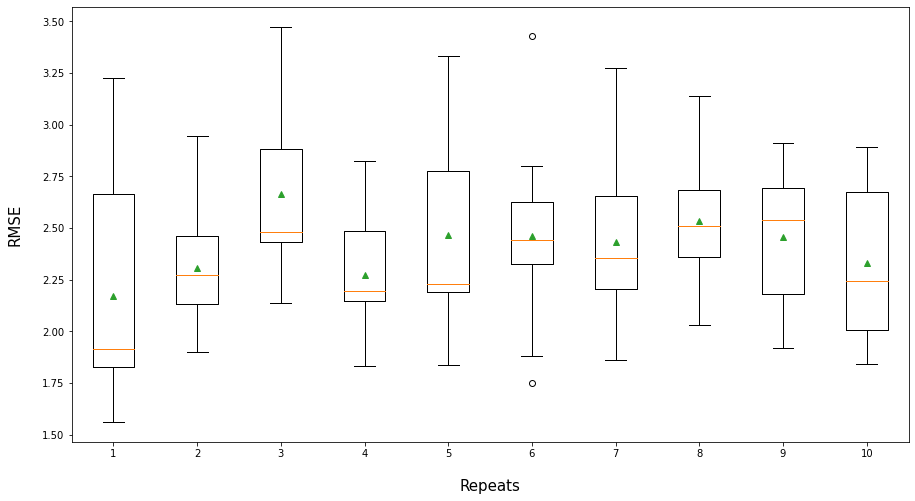

In [11]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)

<h3>Experiment 2</h3>
<h4> Repeated KFold Cross Validation - df_r3d_only</h4>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D is considered.

In [12]:
y = df_r3d_only['R28D'].values
x = df_r3d_only.drop(['Data/Hora', 'R28D'], axis=1).values

In [13]:
rkf2, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 2.241 (0.432)
Minutes Elapsed:  10.025762955347696


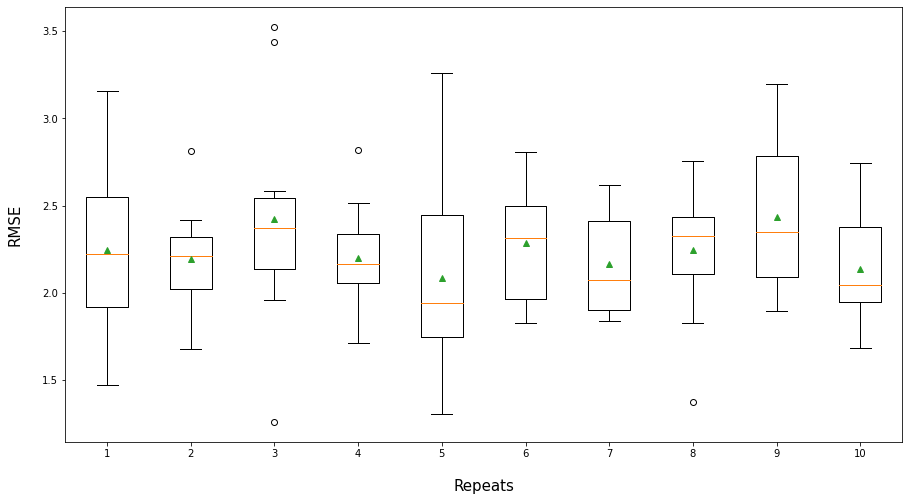

In [14]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)

<h3>Experiment 3</h3>
<h4> Repeated KFold Cross Validation - df_r3d_and_r7d</h4>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D are considered.        

In [15]:
y = df_r3d_and_r7d['R28D'].values
x = df_r3d_and_r7d.drop(['Data/Hora', 'R28D'], axis=1).values

In [16]:
rkf3, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 2.125 (0.499)
Minutes Elapsed:  10.023366220792134


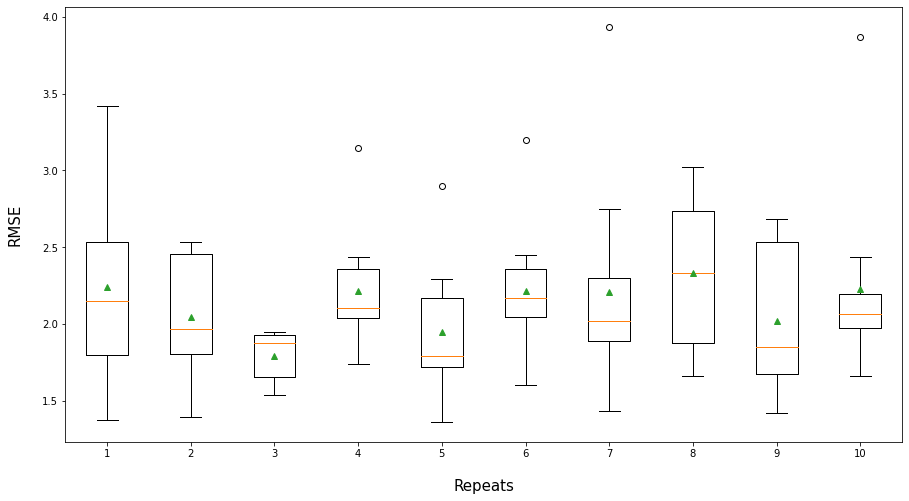

In [17]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)